# Correlate datasets

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import math

In [3]:
import brsflufight_nerc2  as bff2

## Prepare data

In [4]:
data_sets = bff2.load_data_files()

A loading function must be defined in `data_access.default_file_read_functions`.
A loading function must be defined in `data_access.default_file_read_functions`.


Data is loaded into a `DataGroup` which is simply a dictionary which exposes the method `get_country`.

In [5]:
country = 'United Kingdom'

d_uk = data_sets.get_country(country)

Success: historical_GHG_Sectors_GCP
Success: historical_GHG_Sectors_PIK
Success: historical_GHG_Sectors_UNFCCC
Success: mobility_apple
Failed: United Kingdom not in mobility_citymapper
Success: mobility_google
Success: uk_energy_daily


In [6]:
d_uk['uk_energy_yearly'] = d_uk['uk_energy_daily'].groupby(pd.Grouper(freq='1Y')).mean()

## Choose analysis datasets

First we define the datasets and the columns we want to correlate. Implicitely we are emitting the hypothesis:

*Column C in dataset X is correlated to column D in dataset Y.*

for all columns and datasets in the dictionary `to_correlate`

In [7]:
gas = "CO2"
cols_GCP = d_uk['historical_GHG_Sectors_GCP'].columns
cols_GCP = [s for s in cols_GCP if f"({gas})" in s]

to_correlate = {
    'uk_energy_yearly': ['oil', 'ccgt', 'coal', 'demand'],
    'historical_GHG_Sectors_GCP': cols_GCP,
    'historical_GHG_Sectors_PIK': ['Energy (KYOTOGHG)', 'Energy (CO2)', 'Energy (N2O)', 'Energy (CH4)']
}

Once chosen we pass it to function [`correlate`](brsflufight_nerc2/model_predict.py) 
which calculates and returns all the correlation between the data sets as well as linear fits 

In [8]:
correlation_dict = bff2.correlate(selector=to_correlate,data_sets=d_uk,main_compare='uk_energy_yearly')

Linear regression failed for: 'Bunkers (CO2)' fit to  'oil':
  Message: Input contains NaN, infinity or a value too large for dtype('float64').
Linear regression failed for: 'Bunkers (CO2)' fit to  'ccgt':
  Message: Input contains NaN, infinity or a value too large for dtype('float64').
Linear regression failed for: 'Bunkers (CO2)' fit to  'coal':
  Message: Input contains NaN, infinity or a value too large for dtype('float64').
Linear regression failed for: 'Bunkers (CO2)' fit to  'demand':
  Message: Input contains NaN, infinity or a value too large for dtype('float64').


`bff2.correlate` returns a dictionary of dictionaries corresponding to the datasets that were correlated to `main_compare` (in this case `'uk_energy_yearly'`).
For each dataset 3 items are returned:

  + a `'correlation'`: the pearson correlation coefficient between datasets;
  + the merged `'data'` used for the correlation;
  + a linear `'fit'` between the datasets done through `scikit-learn` `LinearRegression`;
 
We can visualise the correlations to identify relationships of interest, we are looking for numbers close to 1.

In [9]:
for dset in correlation_dict:
    print("=====================================================================")
    print(f"Correlations in dataset '{dset}'")
    print("_________________________________________________________")
    display(
        correlation_dict[dset]['correlation']
        .style.background_gradient().set_precision(3)
    )
    print("=====================================================================")
    print("")

Correlations in dataset 'historical_GHG_Sectors_GCP'
_________________________________________________________


,Bunkers (CO2),Cement (CO2),Coal (CO2),Gas (CO2),Gas flaring (CO2),Oil (CO2),Total fossil fuels and cement (CO2)
oil,nan,-0.673,0.955,-0.595,-0.745,-0.901,0.955
ccgt,nan,0.000,-0.321,0.464,0.252,0.643,-0.321
coal,nan,-0.595,0.893,-0.714,-0.667,-0.893,0.893
demand,nan,-0.595,0.893,-0.714,-0.667,-0.893,0.893



Correlations in dataset 'historical_GHG_Sectors_PIK'
_________________________________________________________


,Energy (KYOTOGHG),Energy (CO2),Energy (N2O),Energy (CH4)
oil,0.943,0.943,0.657,0.886
ccgt,-0.314,-0.314,0.143,-0.143
coal,0.829,0.829,0.486,0.771
demand,0.829,0.829,0.486,0.771


Before predicting the emissions based on GHG let us check what the data from which we predict is like

,oil,ccgt,coal,demand
count,10.000000,10.000000,10.000000,10.000000
mean,0.525281,11627.876430,6953.506175,33026.266552
std,0.756537,2222.518145,5846.998852,2587.496620
min,0.000000,9148.029085,679.510313,28489.144958
25%,0.001103,9636.630307,1912.358057,31558.536708
50%,0.154770,11489.689029,5852.376027,32712.718536
75%,0.796898,13560.434154,11184.139849,34955.428258
max,2.309853,14506.012432,15641.439384,36581.013455


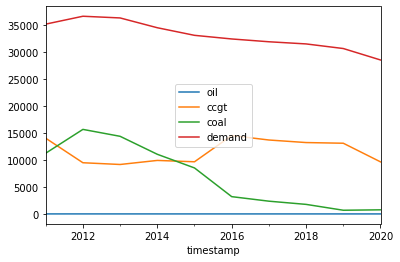

In [10]:
dsource = 'uk_energy_yearly'
d_uk[dsource].plot(y=to_correlate[dsource])
d_uk[dsource][to_correlate[dsource]].describe()

We see that '`oil`' while having high correlation must be ignored as it is almost empty and is definitely not driving GHG emissions: it is 4 orders of magnitude lower than the other fields.

## Predicting GHG emissions from the Energy sector from energy data

From the observed correlation we select to predict emissions based on the 
data from the Potsdam institute for climate impact research (PIK) [called '`historical_GHG_Sectors_PIK`' in our framework] using specifically:

+ 'demand' : The expected average yearly power demand;
+ 'coal' : The expected average yearly power produced by coal plants;
+ 'ccgt' : The expected average yearly power by combined cycle gas turbine plants.

These values are predicted in [`predict.ipynb`]()

In [22]:
prediction_data_set = correlation_dict['historical_GHG_Sectors_PIK']

In [23]:
pred_x = pd.DataFrame( # Dummy values 
    {
        'ccgt':[9000],
        'coal':[700],
        'demand':[28000.0],
    },
    index=pd.to_datetime(["2020"])
)
pred_x

,ccgt,coal,demand
2020-01-01,9000,700,28000.0


Using function `bff2.apply_prediction` applies the linear prediction to each correlated column

In [26]:
pred = bff2.apply_prediction(prediction_data_set['fit'], pred_x)
pred

,,predictor_value,Energy (KYOTOGHG),Energy (CO2),Energy (N2O),Energy (CH4)
predictor,date,,,,,
ccgt,2020-01-01,9000,432.214031,421.665933,2.576720,8.003313
coal,2020-01-01,700,363.274551,354.399020,2.484310,6.571622
demand,2020-01-01,28000,301.841022,294.543148,2.397703,5.025987


It is useful to check here what the correlations between predictors (rows) and predicted values are (columns) 

In [28]:
display(
    prediction_data_set['correlation'].loc[pred.index.get_level_values(0).unique()]
    .style.background_gradient().set_precision(3)
)

,Energy (KYOTOGHG),Energy (CO2),Energy (N2O),Energy (CH4)
predictor,,,,
ccgt,-0.314,-0.314,0.143,-0.143
coal,0.829,0.829,0.486,0.771
demand,0.829,0.829,0.486,0.771


In [13]:
pred_corona = pd.DataFrame(
    {
        'demand_no_corona':[30000.0],
        'demand_corona':[28000.0],
    },
    index=pd.to_datetime(["2020"])
)
pred = bff2.apply_prediction(
    prediction_data_set['fit'],
    pred_corona,
    {c: 'demand' for c in pred_corona}
)

In [14]:
difference = pred.loc["demand_corona"]-pred.loc["demand_no_corona"]
ratio = (difference)/pred.loc["demand_no_corona"]

difference["quantity"] = "absolute difference"
ratio["quantity"] = "relative difference"

change_corona = pd.concat([difference,ratio])

In [15]:
print("Predicted GHG emissions based on energy demand:")
print("___________________________________________________")
display(pred)
print("")
print("")
print("Predicted change in GHG emissions based on energy demand:")
print("_____________________________________________________________")
display(change_corona)

Predicted GHG emissions based on energy demand:
___________________________________________________


,,predictor_value,Energy (KYOTOGHG),Energy (CO2),Energy (N2O),Energy (CH4)
predictor,date,,,,,
demand_no_corona,2020-01-01,30000.0,340.884887,332.572576,2.451594,5.956173
demand_corona,2020-01-01,28000.0,301.841022,294.543148,2.397703,5.025987




Predicted change in GHG emissions based on energy demand:
_____________________________________________________________


,predictor_value,Energy (KYOTOGHG),Energy (CO2),Energy (N2O),Energy (CH4),quantity
date,,,,,,
2020-01-01,-2000.000000,-39.043864,-38.029429,-0.053891,-0.930186,absolute difference
2020-01-01,-0.066667,-0.114537,-0.114349,-0.021982,-0.156172,relative difference


## Plots

In [16]:
energy_demand = d_uk['uk_energy_daily'][['oil', 'ccgt', 'coal', 'demand']]
# energy_ghg = d_uk['historical_GHG_Sectors_PIK']['Energy (KYOTOGHG)']

gas = "CO2"
GHG_data = 'historical_GHG_Sectors_GCP'

cols = d_uk['historical_GHG_Sectors_GCP'].columns
cols_GHG = [s for s in cols if f"({gas})" in s]
energy_ghg = d_uk[GHG_data][cols_GHG]



In [17]:
fig, axs = plt.subplots(1, 1)
fig.set_size_inches(10, 5)
ax1_args = {}
ax2_args = {}
if energy_demand_yearly.shape[1] == 1 and energy_ghg.shape[1] == 1:
    ax1_args = {'color':"C0"}
    ax2_args = {'color':"C1"}
energy_demand_yearly.plot(
    y=[c for c in energy_demand_yearly],
    ax=axs, 
    label=[c for c in energy_demand_yearly],
    **ax1_args
)
ax2 = axs.twinx()
energy_ghg[energy_ghg.index > "2000"].plot(ax=ax2, label="GHG emissions", linestyle='--', **ax2_args)

axs.set_ylabel('Yearly Average Energy [MW]', **ax1_args)
ax2.set_ylabel('Yearly GHG emissions [Mt$CO_2$e/Y] (dashed lines)', **ax2_args)
axs.legend()
ax2.legend()

NameError: name 'energy_demand_yearly' is not defined

In [18]:
merged = pd.merge_asof(
    energy_ghg[energy_ghg.index > "2012"], 
    energy_demand_yearly, 
    left_index=True, right_index=True, direction='nearest')

NameError: name 'energy_demand_yearly' is not defined

In [19]:
merged.corr().style.background_gradient().set_precision(2)

NameError: name 'merged' is not defined

In [20]:
((merged-merged.min())/(merged.max()-merged.min())).plot(x='Coal (CO2)', marker='+')

NameError: name 'merged' is not defined